# Example: Simulating Images with Nonnominal PSFs
---

Throughout JWST OTE commissioning until about MIMF-3 (expected L+118 days), the JWST OTE will not be optimally aligned. The mirrors will be unstacked and unphased, especially for earlier commissioning activities, and thus the nominal JWST PSFs that MIRaGe uses for imaging simulations do not adequately represent the telescope state.

### How to Simulate Images with Nonnominal PSFs
In this notebook, we demonstrate how to simulate images with nonnominal PSFs (as will be the case during OTE commissioning) with MIRaGe. The process is as follows:
- Using `webbpsf`, generate PSF libraries from the desired mirror state for each observation/visit/exposure in a given observation
- Generate MIRaGe YAML input files that include the directory where to find the special PSF libraries
- Generate seed images from those YAMLs that use the appropriate PSF library for any given exposure
- Follow the nominal procedures for adding dark exposure and detector effects

### Table of Contents:
1. [Export program information from APT](#export_apt)
2. [Create diverse PSF library files](#create_psfs)
3. [Create `.yaml` files for each exposure](#make_yamls)
4. [Generate the simulated image](#simulate_images)

Appendix 1: [Generating data for an entire observation](#simulate_whole_obs)

Appendix 2: [Combining data into a mosaic](#mosaic)

<div class="alert alert-block alert-warning">
    
<b>Note:</b> <br>

You must have installed the <code>mirage</code> package before running this notebook. Install it using the following command while in the <code>mirage</code> repository (where the <code>setup.py</code> file is located):<br><br>

<code>pip install -e .</code>

</div>

In [1]:
# Standard Library Imports
import os
import re

# Third Party Imports
import pprint
import shutil
import jwxml
import yaml
import pysiaf
from glob import glob
import numpy as np
# import webbpsf
from astropy.io import fits
from astropy.io import ascii as asc
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# Local Imports (from nircam_simulator package)
from mirage import imaging_simulator
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.apt import apt_inputs
from mirage.yaml import yaml_generator, generate_observationlist
from mirage.catalogs import get_catalog

# View matplotlib plots inline
%matplotlib inline

In [2]:
# Define the location of this file (the examples/ directory)
__location__ = os.getcwd()

---
<a id='export_apt'></a>
# 1. Export APT files

Export the `.pointing` and `.xml` files for your given proposal in APT by selecting `File > Export...` and selecting both the xml and pointing file options. Save them in a place you will remember, naming them something descriptive such as `OTE06_1140.pointing`.

The following APT programs will take place when the mirror segments have not been aligned in an image array:
- 1134 (OTE-01: Initial Image Mosaic)
- 1135 (OTE-02: Alignment Matrix 1)
- 1136 (OTE-03: Secondary Mirror Focus Sweep)
- 1137 (OTE-04: Segment ID)
- 1138 (OTE-05: Alignment Matrix 2)

For this example, we are using APT output from a miniaturized version of program 1134 - OTE-01: Initial Image Mosaic. The neccessary files, `OTE01-1134-reduced_mosaic.pointing` and `OTE01-1134-reduced_mosaic.pointing`, are located within the `examples/unstacked_mirror_data/` directory.

For this example we will simulate images from OTE-06: Segment Image Array. In this stage of commissioning, the mirrors are being moved to place the 18 segments in a hexagonal image array for the first time.

You can load this file in APT by selecting `File > Retrieve from STScI > Retrieve Using Proposal ID` and then entering 1140.
(You must be running APT in STScI mode for this retrieval method to be available.)

In [202]:
prop_id = 1134

# Where the pointing and XML file for this particular OTE CAR are located
input_dir = './unstacked_mirror_data/'

# Change the root if you named your files differently.
root = 'OTE01-{}-reduced_mosaic'.format(prop_id)
pointing_file = os.path.join(input_dir, '{}.pointing'.format(root))
xml_file = os.path.join(input_dir, '{}.xml'.format(root))

### Define location of output files

The process of generating simulated images with MIRaGe produces a lot of files:
- YAMLs carrying the OTE mirror state
- FITS files of the segment PSF images
- YAMLs carrying the specifications for simulations
- FITS files of the simulated seed, dark, and compiled images

We'll save those also in a local directory here:

In [177]:
# Where to save MIRaGe output
out_dir = './unstacked_mirror_data_output/'

# Where the segment PSF library files will be saved to (and read from!)
library_dir = './unstacked_mirror_data_output/gridded_psf_library/'

# Make sure both these directories exist
for full_path in [out_dir, library_dir]:
    if not os.path.exists(full_path):
        os.makedirs(full_path)

---
<a id='create_psfs'></a>
# 2. Create diverse PSF library files

Let's simulate Image Array 1 (OTE-06).
It has 6 observations:
- The first 5 observations are WFSC Commissioning observations, that each include 18 WFC groups. (18 sets of image-move-image. Right?)
- The last observation is simply NIRCam imaging to see how we did.

So I will need 5 x 18 = 90 distinct PSF library files. 

In [77]:
# Create dictionary that mirrors the program structure
program_structure = {}
for i in range(n_exposures):
    obs_num = pointing_tab['obs_num'][i]
    visit_num = pointing_tab['visit_num'][i]
    activity_id = pointing_tab['act_id'][i]
    
    obs_key = 'Observation{}'.format(obs_num)
    visit_key = 'Visit{}'.format(visit_num)
    
    program_structure.setdefault(obs_key, {})
    visit_dict = program_structure[obs_key].setdefault(visit_key, []).append('Activity{}'.format(activity_id))                                                                      
    
pprint.pprint(program_structure)  

{'Observation001': {'Visit001': ['Activity01',
                                 'Activity02',
                                 'Activity03',
                                 'Activity04',
                                 'Activity05',
                                 'Activity06',
                                 'Activity07',
                                 'Activity08',
                                 'Activity09',
                                 'Activity0a',
                                 'Activity0b',
                                 'Activity0c',
                                 'Activity0d',
                                 'Activity0e',
                                 'Activity0f',
                                 'Activity0g',
                                 'Activity0h',
                                 'Activity0i',
                                 'Activity0j']},
 'Observation002': {'Visit001': ['Activity0k',
                                 'Activity0l',
           

In [8]:
# Create directory structure based on dictionary

psf_paths = []
program_dir = os.path.join(library_root_dir, root)
for observation in program_structure.keys():
    for visit in program_structure[observation].keys():
        for activity in program_structure[observation][visit]:
            activity_dir = os.path.join(program_dir, observation, visit, activity)
            if not os.path.exists(activity_dir):
                os.makedirs(activity_dir)
            psf_paths.append(activity_dir)

## Generate the original PSF array

In [24]:
# Generate original PSF

# Let's go for a global alignment-esque thing, with the image array and random pistons.
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

# Set up the array
webbpsf.opds.setup_image_array(ote, reset=True, verbose=False, size='large', )

# Add random pistons
random_pistons = np.random.randn(18)*500  # substantial coarse phasing erorrs. 
for i, seg in enumerate(ote.segnames[0:18]):  # don't piston "segment 19" the SM
    ote.move_seg_local(seg, piston=random_pistons[i])

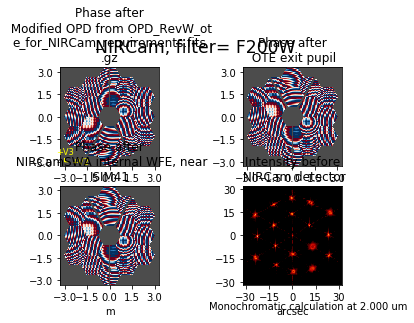

In [8]:
original_psf = nc.calc_psf(monochromatic=2e-6, oversample=1, fov_pixels=2048, display=True)

## Make slightly different PSFs for every exposure

In [29]:
def create_lib_for_random_ote(i):
    start_time = time.time()
    obs = 'Observation{}'.format(pointing_tab['obs_num'][i])
    visit = 'Visit{}'.format(pointing_tab['visit_num'][i])
    visit_dir = os.path.join(program_dir, obs, visit)
    
    print('Calculating PSF for obs {}, visit {}, exposure {}'
          .format(pointing_tab['obs_num'][i], pointing_tab['visit_num'][i], i + 1))

    i_seg = random_segments[i]
    ote.move_seg_local(ote.segnames[i_seg], piston = random_pistons[i])

    library_filename = 'nircam_f212n_fovp2048_samp1_npsf1_exp{}.fits'.format(i + 1)
    c = psf_library.CreatePSFLibrary('NIRCam', filters='F212N', detectors='NRCA3', 
                                     fov_pixels=2048, oversample=1, num_psfs=1, 
                                     fileloc=visit_dir, filename=library_filename,
                                     pupil_opd=ote, overwrite=False)
    c.create_files()
    
    print('Elapsed time: {}\n'.format(time.time() - start_time))

In [15]:
# Define a beep noise
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)

In [26]:
# Determine how many cores I have
multiprocessing.cpu_count()

32

<div class="alert alert-warning">
    
<b>Attention!</b><br>

Note that the following cell is meant to be executed on a remote server which has <b>32 processors</b>! If you run it on your own machine, bad and unpredictable things may happen. Be careful to use fewer processors than are on your computer. 

</div>

In [ ]:
# Generate PSF library files for each exposure - WITH MULTIPROCESSING!:
n_exposures = len(pointing_tab['visit_id'])

random_segments = np.random.randint(0, 17, n_exposures)
random_pistons = np.random.randn(n_exposures)*500

p = multiprocessing.Pool(30)
p.map(create_lib_for_random_ote, range(n_exposures))
    
beep(5)

---
<a id='make_yamls'></a>
# 3. Create YAML files for each exposure

Next, we need to make the YAML files that include all of the parameters for MIRaGe to run.

### Query online catalogs to generate catalog files of sources in FOV

Next, we need to generate catalog files for the sources around the target in this proposal. First we must parse the `.pointing` file to determine the RA and Dec of the target (or targets) that will be observed. Then we will query 2MASS and WISE to get the magnitudes and locations of shortwave and longwave sources, respectively, around the target.

All of this can be accomplished with the `mirage.get_catalog.get_all_catalogs` function.

These catalog files will be written to your local `mirage/catalogs/` directory. If files for a given catalog and RA/Dec have already been generated, they will not be regenerated.

<div class="alert alert-block alert-warning">
    
<b>Important:</b> <br>

Querying 2MASS and WISE is only appropriate for observations with the F212N and F480M NIRCam filters. If you want to simulate observations that use other filters, you will have to either query different bandpasses or catalogs or perform a photometric conversion on an existing catalog.

</div>

In [4]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

cat_dict = {'nircam': {'lw': catalog_filenames_lw,
                       'sw': catalog_filenames_sw}}

Target coordinates:  146.87731 63.24781
Shortwave catalog file 2MASS_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.
Longwave catalog file WISE_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.


### Generate the `.yaml` files

Use `mirage.yaml.yaml_generator` to make all of the YAML files for the given APT program - one file per exposure.

**Some additional settings are required to ensure `yaml_generator` works for nonnominal PSF simulations.** You must specify the following attributes before running `create_inputs()` to make the YAMLs, and thus simulations, correctly:
- `yam.psf_paths = os.path.expandvars(library_dir)` - tells MIRaGe to look in `library_dir` to find the FITS files for every exposure

In [6]:
# Create a series of data simulator input yaml files from APT files
# (Within this, create the observation table.)
yam = yaml_generator.SimInput(input_xml=xml_file, pointing_file=pointing_file,
                              catalogs=cat_dict,
                              verbose=True, output_dir=ote_dir, simdata_output_dir=ote_dir)
yam.psf_paths = os.path.expandvars('$MIRAGE_DATA/nircam/test_webbpsf_library')
yam.create_inputs()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `Form medium array` uses template `WfscCommissioning`
APTObservationParams Dictionary holds 0 entries before reading template
Dictionary read from template has 19 entries.
Found 0.0 tile(s) for observation 001 Form medium array
Found 1 visits with numbers: [1]
APTObservationParams Dictionary holds 19 entries after reading template (+19 entries)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `002` labelled `Clean up or form large array` uses template `WfscCommissioning`
APTObservationParams Dictionary holds 19 entries before reading template
Dictionary read from template has 19 entries.
Found 0.0 tile(s) for observation 002 Clean up or form large array
Found 1 visits with numbers: [1]
APTObservationParams Dictionary holds 38 entries after reading template (+19 entries)
+++++++++++++++++++++++++++

## Let's examine where the sources will fall in an example exposure

### Examine target pointings relative to apertures and V2/V3 references

Looking at the `.pointing` file, let's plot where the target will appear relative to the NIRCam apertures for each unique pointing.

Example files for each pointing:
--------------------------------
1. jw01140002001_0110m_00001_nrca4.yaml
2. jw01140006001_0112o_00001_nrca2.yaml
11. jw01140006001_0112q_00001_nrcb2.yaml
41. jw01140006001_0112r_00001_nrca2.yaml
60. jw01140006001_0112p_00001_nrcb3.yaml


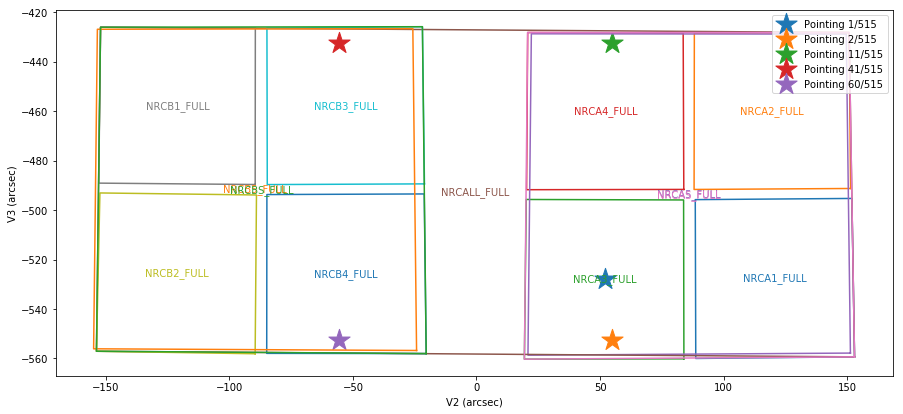

In [8]:
# Examine apertures and V2/V3 references for each array/subarray
nc_siaf = pysiaf.Siaf('NIRCam')
nc_full = nc_siaf['NRCA1_FULL']

plt.figure(figsize=(15,10))
for apername in sorted(nc_siaf.apernames):
    a = apername
    if ('_FULL' in a) and ('OSS' not in a) and ('MASK' not in a) and (a[-1] != 'P'):
        nc_siaf[a].plot(frame='tel', name_label=a, fill_color='white')
plt.gca().invert_xaxis()

# Compare V2/V3 of targets (from .pointing file)
all_pointings = set([(v2, v3, filename) for v2, v3, filename in zip(yam.info['v2'], 
                                                                yam.info['v3'], 
                                                                yam.info['yamlfile'])])

print('Example files for each pointing:')
print('--------------------------------')
plotted_points = []
for i_point, (v2, v3, filename) in enumerate(all_pointings):
    if (v2, v3) not in plotted_points:
        plotted_points.append((v2, v3))
        plt.scatter(v2, v3, marker='*', s=500, 
                    label='Pointing {}/{}'.format(i_point + 1, len(all_pointings)))
        print('{}. {}'.format(i_point + 1, filename))

plt.legend()

plt.show()

MIRaGE can only generate one simulated exposure at a time, so even though we have 135 yaml files in our `ote_dir` directory, we need to choose just one to produce an image. Since each exposure points in a different place, we should choose an exposure that places the target star in the desired detector FOV.

It looks like pointing number 1 in the A3 detector would be a good choice (the blue star in the green left box). So, looking at the printed output, we want to use the yaml called `jw01140005001_0112n_00001_nrca3.yaml`.

> Note: as described on [JDox](https://jwst-docs.stsci.edu/display/JDAT/File+Naming+Conventions+and+Data+Products), the yaml files are named like so:<br><br>
> `jw<PPPPP><OOO><VVV>_<GGSAA>_<EEEEE>_<detector>.yaml`<br><br>
> where:
> * P = proposal number
> * O = observation number
> * V = visit number
> * G = Visit Group
> * S = Parallel Sequence id (1 prime, 2-5 parallel)
> * A = Activity number (base 36)
> * E = exposure number
> 
> So `jw01140005001_0112n_00001_nrca3.yaml` would be the first visit in the fifth observation of APT proposal 1140, exposure 1, taken with the A3 detector.

In [9]:
file_name_to_match = 'jw01140004001'
yaml_to_sim = [y for y in yfiles if file_name_to_match in y][2]
# yaml_to_sim = os.path.join(ote_dir, 'jw01140005001_0112f_00001_nrca3.yaml')
print(yaml_to_sim)

/Users/lchambers/TEL/mirage/mirage_repo/examples/ote_data/jw01140004001_0111y_00001_nrca3.yaml


---
<a id='simulate_images'></a>
# 4. Simulate image with MIRaGe

Finally, we can run MIRaGe to generate a seed image simulation of our unstacked mirror state during OTE-01.

From here on out, from the user perspective, the simulation process is identical for nominal imaging cases (see the [imaging example notebook](#Imaging_simulator_use_examples.ipynb). The specifications made in the YAML files are what enable the specialized behavior needed to simulate unstacked mirror simulations with MIRaGe.

In [220]:
print(test_yaml)

'./unstacked_mirror_data_output/yamls/jw01134001002_01106_00001_nrca3.yaml'

In [230]:
img_sim = imaging_simulator.ImgSim()
img_sim.paramfile = test_yaml
img_sim.create()

Requested readout pattern BRIGHT1 is valid. Using the nframe = 1 and nskip = 1
No galaxy catalog provided in yaml file.
NOTE: Using pre-delivery SIAF data for NIRCam
SIAF: Requested NRCA3_FULL   got NRCA3_FULL
Calculating background rate using jwst_background based on low level
Using /Users/lchambers/TEL/mirage/mirage_repo/mirage/config/F212N_nircam_plus_ote_throughput_moda_sorted.txt filter throughput file for background calculation.
Background level set to: 4.696657982663226e-05
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
output dimensions are: [2048 2048]
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Frametime is 10.736770000000002
Segment PSFs will be generated using:
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg01.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg02.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg03.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg04.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg05.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg06.fits
nircam_nrca3_f212n_fovp1024

WCS info for /Users/lchambers/TEL/mirage/mirage_repo/examples/unstacked_mirror_data_output/jw01134001002_01106_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/Users/lchambers/TEL/mirage/mirage_repo/examples/unstacked_mirror_data_output/jw01134001002_01106_00001_nrca3_linear.fits
Observation generation complete.


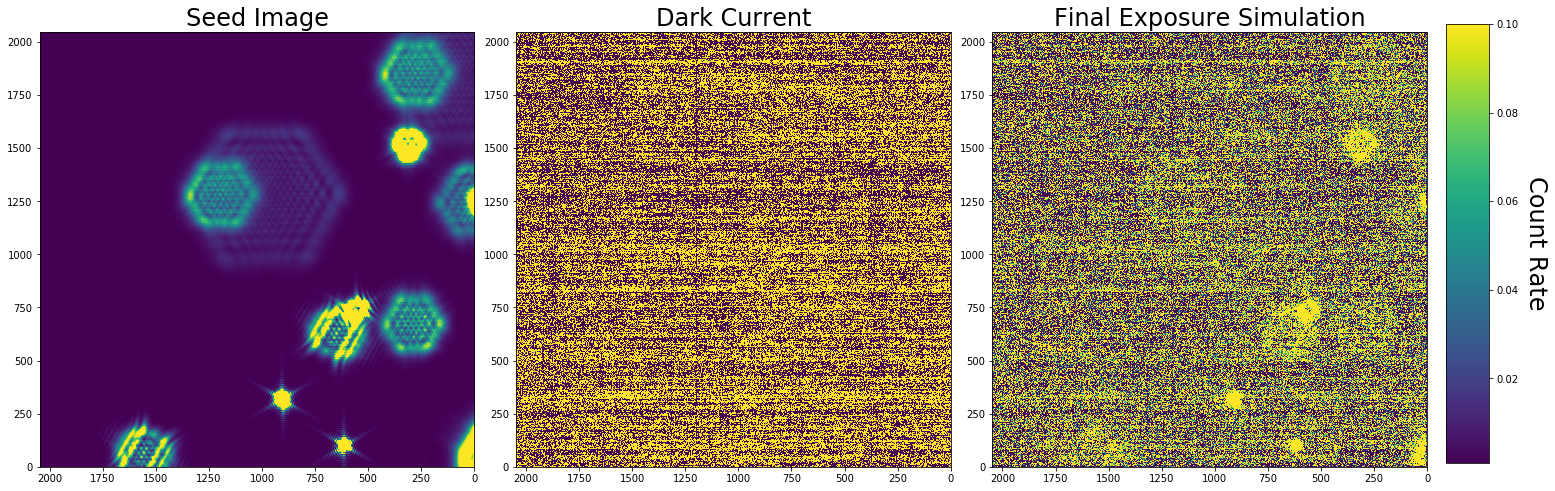

In [251]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 7))
plt.tight_layout()

fitsplot = ax1.imshow(img_sim.seedimage, clim=(0.001, 0.1))
ax1.set_title('Seed Image', size=24)
ax1.invert_xaxis()
ax1.invert_yaxis()

ax2.imshow(img_sim.linDark.data[0,-1,:,:] - img_sim.linDark.data[0,0,:,:], clim=(0.001, 0.1))
ax2.set_title('Dark Current', size=24)
ax2.invert_xaxis()
ax2.invert_yaxis()

linear_output = './unstacked_mirror_data_output/jw01134001002_01106_00001_nrca3_linear.fits'
with fits.open(linear_output) as h:
    lindata = h[1].data
    header = h[0].header
exptime = header['EFFINTTM']
diffdata = (lindata[0,-1,:,:] - lindata[0,0,:,:]) / exptime

ax3.imshow(diffdata, clim=(0.001, 0.1))
ax3.set_title('Final Exposure Simulation', size=24)
ax3.invert_xaxis()
ax3.invert_yaxis()

# Define the colorbar
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = plt.colorbar(fitsplot, cbar_ax)
cbar.set_label('Count Rate', rotation=270, labelpad=30, size=24)

---
<a id='simulate_whole_obs'></a>
# Appendix 1: Simulating many exposures at once

Chances are, you don't want to simulate just one exposure from one detector. In order to simulate all of the exposures from a given observation, write a for loop to iterate over all the YAMLs. We include an example for program 1134 observation 1 below.

### 1. Create all PSF library files
First, make sure that you have created library files for all of the filters and detectors that will be simulated in your observation (for program 1134 observation 1 this means all detectors and filters F212N and F480M):
```python
from mirage.psfs import segment_psfs

segment_psfs.generate_segment_psfs(ote, segment_tilts, library_dir, 
                                   filters=['F212N', 'F480M'], detectors='all')
```

### 2. Run `imaging_simulator` for all YAMLs
Second, grab all of the YAMLs for that specific observation and run the whole image simulator on them all.
```python
from mirage import imaging_simulator

# Get all the 1134 Obs 1 NRCA3 yamls
all_yaml_files = glob(ote_dir + 'jw01134001*.yaml')
n_yamls = len(all_yaml_files)
print('{} FITS files will be generated.'.format(n_yamls))

for yaml in all_yaml_files:
    print('*** SIMULATING YAML {}/{}: {} ***'.format(i+1, n_yamls, yaml))
    img_sim = imaging_simulator.ImgSim()
    img_sim.paramfile = yaml
    img_sim.create()
```

(If you are impatient and ambitious, you can use Python's `multiprocessing` module to the simulation go faster. Even better on a server with more processors! See the [Non-nominal PSF example notebook](#Nonnominal_PSF_simulations_use_examples.ipynb) for a working example of that.)

---
<a id='mosaic'></a>
# Appendix 2: Combine into a mosaic

### Turn linear FITS products into slope images
```python
obs1_fits = glob(os.path.join(ote_dir, 'jw*linear.fits'))
print('{} FITS files produced for program APT 1134 Observation 1'.format(len(obs1_fits)))

# Subtract the first from last for each ramp
for f in obs1_fits:
    with fits.open(f) as hdulist:
        data = hdulist[1].data
        hdr = hdulist[1].header
        
    diff = data[0, -1] - data[0, 0]

    hdu = fits.PrimaryHDU(data=diff, header=hdr)

    new_filename = os.path.join(ote_dir, 'slope_fits', os.path.basename(f))
    hdu.writeto(new_filename, overwrite=True)
    
obs1_slope_fits = glob(os.path.join(ote_dir, 'slope_fits', 'jw*linear.fits'))
```


### Make ops file for QUIP
```python
# Set variables for writing QUIP ops file
outdir = os.path.join(out_dir, 'quip')
outfile = 'congrid'
bindim = 2048
opsfile = outdir+'ops_file_'+outfile.strip("/")+str(bindim)+'.xml'

# Write the file
f = open(opsfile,'w')

f.write('<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n')
f.write('<QUIP_OPERATION_FILE xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" creator="WSS Executive" time="16:22:40.093Z" date="2017-06-14Z" version="6.0.1" operational="false" xsi:noNamespaceSchemaLocation="/Users/lajoie/TEL/WSS-6.0.1/Software/schema/quip_operation_file.xsd">\n')
f.write('    <CORRECTION_ID>R2017061401</CORRECTION_ID>\n')
f.write('    <OPERATION_TYPE>THUMBNAIL</OPERATION_TYPE>\n')
f.write('    <IMAGES>\n')

for filename in obs1_slope_fits:
    f.write("       <IMAGE_PATH>{:s}</IMAGE_PATH>\n".format(filename))
    
f.write( '       </IMAGES>\n'    )
f.write( '       <OUTPUT>\n')
f.write( '           <OUTPUT_DIRECTORY>{:s}quip/</OUTPUT_DIRECTORY>\n'.format(outdir))
f.write( '           <LOG_FILE_PATH>{:s}quip/R2017061401_quip_activity_log.xml</LOG_FILE_PATH>\n'.format(outdir))
f.write( '           <OUT_FILE_PATH>{:s}quip/R2017061401_quip_out.xml</OUT_FILE_PATH>\n'.format(outdir))
f.write( '       </OUTPUT>\n')

f.write('</QUIP_OPERATION_FILE>\n')

f.close()

print('Successfully wrote QUIP ops file to', opsfile)
```